Проверить статистические зависимости, найти и сопоставить аномалии,причины этих аномалий(выбросов).
Есть ли связь между подписчиками, друзьями, полом, активностью, связь постов и репостов.
Что является главным в популярности(подписчики) и в приверженности(друзья)?

In [104]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
import plotnine as p9
import numexpr as ne
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from pandas._config import get_option
import pandas_profiling 
from pandas._libs.lib import values_from_object
import statsmodels.stats.power as pwr
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import seaborn as sns
from pandas.core.dtypes.generic import ABCDataFrame
from pandas.core.computation.check import _NUMEXPR_INSTALLED
if _NUMEXPR_INSTALLED:
    import numexpr as ne


In [21]:
pd.get_option('compute.use_numexpr') 

True

In [22]:
# df = pd.read_csv('/home/mikhail/Рабочий стол/MatStat_DataSet/reviews.csv')
df = pd.read_csv('/home/mikhail/Рабочий стол/MatStat_DataSet/newDataBaseVk.csv')

# df.info(), 
df.info(), df.head(), df.isnull().sum(), pd.isna(df).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 10 columns):
ID                   998 non-null int64
countFriends         998 non-null int64
countFollowers       998 non-null int64
boolComments         998 non-null bool
countOwnerPosts      998 non-null int64
countOwnerReposts    998 non-null int64
countPhotos          998 non-null int64
countVideos          998 non-null int64
countLikesPhotoes    998 non-null int64
sex                  998 non-null int64
dtypes: bool(1), int64(9)
memory usage: 71.3 KB


(None,
         ID  countFriends  countFollowers  boolComments  countOwnerPosts  \
 0  3329071            75             137         False               11   
 1  5138784           173             117         False                6   
 2  5432192           324             549         False               20   
 3  7245154           678              97         False                1   
 4  8648939           398              38         False               14   
 
    countOwnerReposts  countPhotos  countVideos  countLikesPhotoes  sex  
 0                  9            4           71                 14    2  
 1                 14            9           26                234    1  
 2                  0           40           64               1561    1  
 3                 19           24          240               1111    2  
 4                  6           11           12                480    1  ,
 ID                   0
 countFriends         0
 countFollowers       0
 boolComments     

In [108]:
pandas_profiling.ProfileReport(df)


In [23]:
df.describe()

,ID,countFriends,countFollowers,countOwnerPosts,countOwnerReposts,countPhotos,countVideos,countLikesPhotoes,sex
count,9.980000e+02,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000,998.000000
mean,1.853378e+08,1459.549098,807.098196,9.320641,6.146293,16.692385,361.575150,1443.033066,1.588176
std,1.318300e+08,2241.602534,2926.420603,7.193374,6.549299,28.669853,750.217754,3645.569151,0.492410
min,1.626720e+05,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8.193883e+07,201.250000,85.250000,2.000000,0.000000,3.000000,17.000000,145.250000,1.000000
50%,1.610586e+08,421.500000,233.000000,8.000000,3.000000,7.000000,80.000000,482.500000,2.000000
75%,2.684633e+08,1602.500000,549.750000,17.000000,11.000000,18.000000,363.000000,1509.500000,2.000000
max,5.509817e+08,9998.000000,57037.000000,20.000000,20.000000,275.000000,7719.000000,76595.000000,2.000000


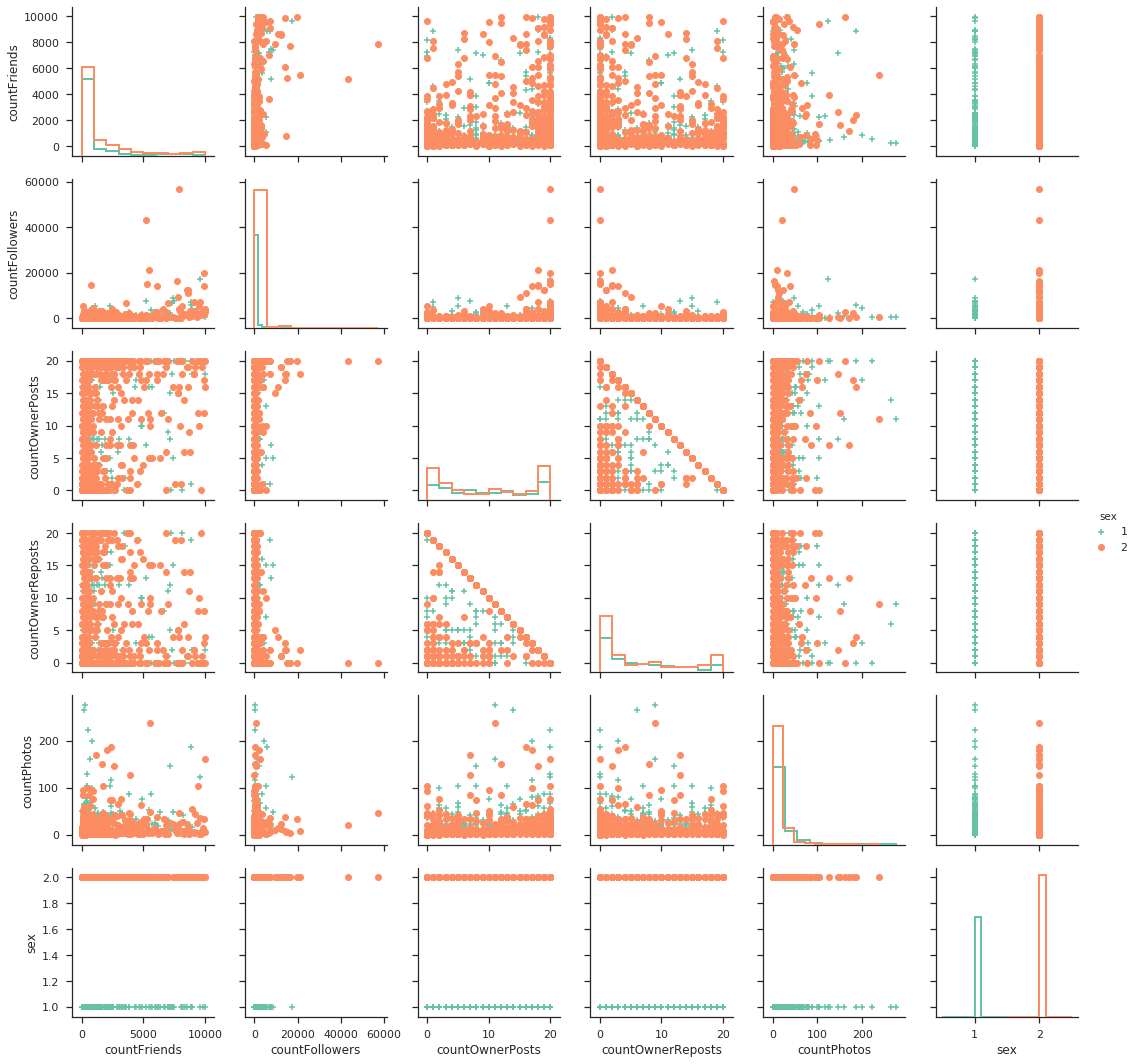

In [109]:
g = sns.PairGrid(df,vars=['countFriends', 'countFollowers', 'countOwnerPosts', 'countOwnerReposts','countPhotos', 'sex'], hue="sex", palette="Set2",
                 hue_kws={"marker": ['+', 'o']})

g = g.map_diag(plt.hist, histtype="step", linewidth=2)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()
# Очень сильно заметны "Горбы и хвост"

In [94]:
#Разобьем для подробного анализа на датафрейм на несколько частей
#Делить будем по 'countFriends'
df_low_head= df.loc[(df['countFriends']<500)]

df_low= df.loc[(df['countFriends']>501)&(df['countFriends']<1799)]

df_med= df.loc[(df['countFriends']>1800) & (df['countFriends']<4999)]

df_hight = df.loc[(df['countFriends']>5000)]

df_low_head.info(),df_low.info(),df_med.info(), df_hight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 544 entries, 0 to 997
Data columns (total 10 columns):
ID                   544 non-null int64
countFriends         544 non-null int64
countFollowers       544 non-null int64
boolComments         544 non-null bool
countOwnerPosts      544 non-null int64
countOwnerReposts    544 non-null int64
countPhotos          544 non-null int64
countVideos          544 non-null int64
countLikesPhotoes    544 non-null int64
sex                  544 non-null int64
dtypes: bool(1), int64(9)
memory usage: 43.0 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 3 to 993
Data columns (total 10 columns):
ID                   221 non-null int64
countFriends         221 non-null int64
countFollowers       221 non-null int64
boolComments         221 non-null bool
countOwnerPosts      221 non-null int64
countOwnerReposts    221 non-null int64
countPhotos          221 non-null int64
countVideos          221 non-null int64
countLikesPhotoes    221

(None, None, None, None)

<ggplot: (8731235256377)>
<ggplot: (8731235267683)>
<ggplot: (-9223363305621279733)>
<ggplot: (8731233499007)>


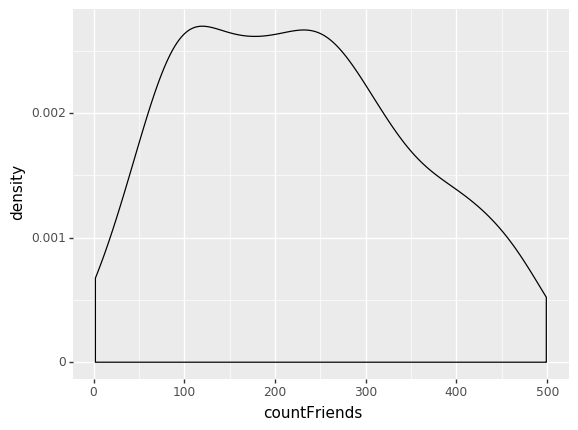

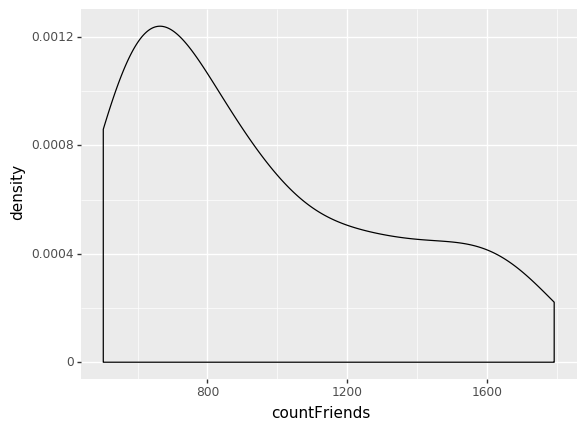

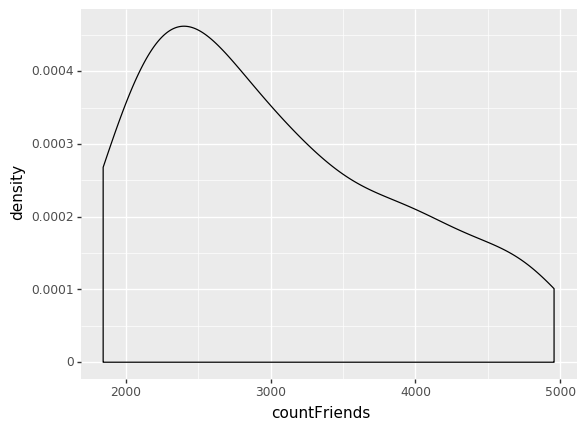

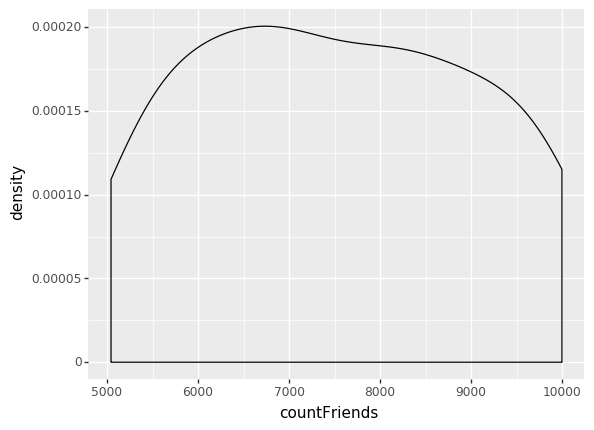

In [119]:
print(p9.ggplot(df_low_head)+p9.aes(x='countFriends',fill='countFollowers')+ p9.geom_density(alpha=0.5))
print(p9.ggplot(df_low)+p9.aes(x='countFriends',fill='countFollowers')+ p9.geom_density(alpha=0.5))
print(p9.ggplot(df_med)+p9.aes(x='countFriends',fill='countFollowers')+ p9.geom_density(alpha=0.5))
print(p9.ggplot(df_hight)+p9.aes(x='countFriends',fill='countFollowers')+ p9.geom_density(alpha=0.5))
# в получившихся группах данные распределены ненормально
# самая большая плотность распределения в группе df_low_head, с количеством друзей до 500, 
# самая низкая в группе df_hight, с количеством друзей более 5_000


In [111]:
name = ['countFriends', 'countFollowers', 'boolComments',
       'countOwnerPosts', 'countOwnerReposts', 'countPhotos', 'countVideos',
       'countLikesPhotoes', 'sex']

Выясним оптимальный размер выборки>>>

In [131]:
# Выполним двустороннюю ANOVA, чтобы проверить, оказывает ли , 
# количество постов, количество репостов 
# или взаимодействие между числом фолловеров и числом фотографий 
# существенное влияние на количество друзей.

df_low_head, df_low, df_med, df_hight

model_1 = sm.api.formula.ols('countFriends ~ countOwnerPosts + countOwnerReposts + countFollowers:countPhotos', 
                             data = df_low_head).fit()
model_2 = sm.api.formula.ols('countFriends ~ countOwnerPosts + countOwnerReposts + countFollowers:countPhotos', 
                             data = df_med).fit()
model_3 = sm.api.formula.ols('countFriends ~ countOwnerPosts + countOwnerReposts + countFollowers:countPhotos', 
                             data = df_hight).fit()

# Выполним двустороннюю ANOVA, чтобы проверить, оказывает ли , 
# количество количество фотографий, количество репостов 
# или взаимодействие между числом фолловеров и полом
# существенное влияние на количество друзей

model_4 = sm.api.formula.ols('countFriends ~ countPhotos + countOwnerReposts + countFollowers:sex', 
                             data = df_low_head).fit()
model_5 = sm.api.formula.ols('countFriends ~ countPhotos + countOwnerReposts + countFollowers:sex', 
                             data = df_med).fit()
model_6 = sm.api.formula.ols('countFriends ~ countPhotos + countOwnerReposts + countFollowers:sex', 
                             data = df_hight).fit()
# Extract our table
aov_table_1 = sm.api.stats.anova_lm(model_1, typ=2)
aov_table_2 = sm.api.stats.anova_lm(model_2, typ=2)
aov_table_3 = sm.api.stats.anova_lm(model_3, typ=2)
aov_table_4 = sm.api.stats.anova_lm(model_4, typ=2)
aov_table_5 = sm.api.stats.anova_lm(model_5, typ=2)
aov_table_6 = sm.api.stats.anova_lm(model_6, typ=2)
# Print the table
print('df_low_head_Photo')
print(aov_table_1)
print()
print('df_med_Photo')
print(aov_table_2)
print()
print('df_hight_Photo')
print(aov_table_3)
print()
print('df_low_head_Gender')
print(aov_table_4)
print()
print('df_med_Gender')
print(aov_table_5)
print()
print('df_hight_Gender')
print(aov_table_6)



df_low_head_Photo
                                  sum_sq     df          F    PR(>F)
countOwnerPosts             2.432518e+05    1.0  16.655998  0.000052
countOwnerReposts           1.182507e+05    1.0   8.096887  0.004603
countFollowers:countPhotos  8.374260e+04    1.0   5.734043  0.016979
Residual                    7.886408e+06  540.0        NaN       NaN

df_med_Photo
                                  sum_sq     df         F    PR(>F)
countOwnerPosts             1.044177e+06    1.0  1.327528  0.251282
countOwnerReposts           9.799730e+05    1.0  1.245901  0.266320
countFollowers:countPhotos  2.606151e+05    1.0  0.331336  0.565832
Residual                    1.061853e+08  135.0       NaN       NaN

df_hight_Photo
                                  sum_sq    df         F    PR(>F)
countOwnerPosts             4.283373e+04   1.0  0.018472  0.892197
countOwnerReposts           1.482438e+04   1.0  0.006393  0.936451
countFollowers:countPhotos  2.912665e+06   1.0  1.256112  0.265403

http://statsoft.ru/home/textbook/modules/stnonpar.html

statsoft.ru/products/STATISTICA_Base/analysis-of-variance.php#step2

https://your-scorpion.ru/anova-bootstrap-check-ml-statistics/